tgb - 1/20/20 - Make six-panel figure about the decomposition of the MSE potential. For convenience, we repeat the figures in the main text:  
- Figures 1a and 1b become a and b with the MSE fields and the moist meander  
- Figures 2a and 2b become c and d with the MSE potential and PDF overlaid  
- The last panels e and f are about the potential's decomposition into different contributions

# Initialization

## Imports

In [1]:
# Initial imports
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve
import util.pdf as PDF

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.transforms as mtransforms
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd

import pickle

In [2]:
# Figure characteristics common to all Figures
fz = 15
lw = 3
siz = 10

plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

# Physical constants
stday = 24*3600

## Utilities

In [3]:
class Bunch(object):
  
    def __init__(self, adict):
        self.__dict__.update(adict)

In [4]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [5]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

In [6]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind

# COSMO

## Panel a and c: Field, contour and PDF

In [7]:
path_RCE = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/output/'

In [8]:
RCE300 = xr.open_mfdataset(path_RCE+'lfff????????.nc')

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [9]:
RCE300

<xarray.Dataset>
Dimensions:       (bnds: 2, level1: 75, rlat: 506, rlon: 506, soil1: 10, srlat: 506, srlon: 506, time: 2400)
Coordinates:
  * rlon          (rlon) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * rlat          (rlat) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * srlon         (srlon) float32 0.015 0.044999998 ... 15.135 15.165
  * srlat         (srlat) float32 0.015 0.044999998 ... 15.135 15.165
    lon           (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 15.149995
    lat           (rlat, rlon) float32 -2.504478e-06 ... 15.149999
    height_2m     float32 2.0
    height_toa    float32 33250.0
  * soil1         (soil1) float32 0.005 0.025 0.07 0.16 ... 1.47 2.86 5.74 11.5
  * time          (time) datetime64[ns] 2011-07-12T12:00:00 ... 2011-10-20T11:00:00
Dimensions without coordinates: bnds, level1
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<shape=(2400, 2), chunksize=(1, 2)>
    rotated_pole  (time) |S1 b'' b'' b'' b'' b''

Find percentile of antimode

In [10]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

In [12]:
MSE_PDF_SPIN,SPINedges = np.histogram(RCE300.FMSE[:(24*COALstart),:,:],bins=100,density=True)
MSE_PDF_COAL,COALedges = np.histogram(RCE300.FMSE[(24*COALstart):(24*COARstart),:,:],bins=100,density=True)
MSE_PDF_COAR,COARedges = np.histogram(RCE300.FMSE[(24*ENDstart):,:,:],bins=100,density=True)

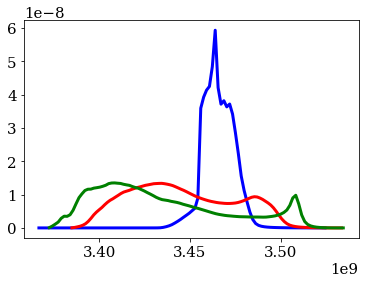

In [13]:
plt.plot(edgTObin(SPINedges),MSE_PDF_SPIN,color='b')
plt.plot(edgTObin(COALedges),MSE_PDF_COAL,color='r')
plt.plot(edgTObin(COARedges),MSE_PDF_COAR,color='g')

In [22]:
np.argmin(MSE_PDF_COAR[20:85])+20

72

In [23]:
SPIN_p88 = np.percentile(RCE300.FMSE[:(24*COALstart),:,:],72)
COAL_p88 = np.percentile(RCE300.FMSE[(24*COALstart):(24*COARstart),:,:],72)
COAR_p88 = np.percentile(RCE300.FMSE[(24*ENDstart):,:,:],72)

In [24]:
MSE_PDF_COAR[72]

3.2273898614867812e-09

In [25]:
SPIN_p88

3470737664.0

In [26]:
SPIN_p88 = np.array([SPIN_p88,MSE_PDF_SPIN[72]])
COAL_p88 = np.array([COAL_p88,MSE_PDF_COAL[72]])
COAR_p88 = np.array([COAR_p88,MSE_PDF_COAR[72]])

In [38]:
MSE_agg = RCE300.FMSE[(24*ENDstart):].mean(dim='time')
toplot = MSE_agg.values

In [30]:
dx = 3.3
x = dx*MSE_agg.rlon
y = dx*MSE_agg.rlat

In [33]:
COARbin = edgTObin(COARedges)
COARbnorm = COARbin - COARbin.mean()

In [34]:
COARbnorm

array([-81006590., -79369980., -77733380., -76097020., -74460670.,
       -72824060., -71187460., -69551100., -67914500., -66277890.,
       -64641536., -63005184., -61368576., -59731970., -58095616.,
       -56459010., -54822400., -53186050., -51549696., -49913090.,
       -48276480., -46640130., -45003520., -43366910., -41730560.,
       -40094210., -38457600., -36820990., -35184640., -33548032.,
       -31911424., -30275072., -28638720., -27002112., -25365504.,
       -23729152., -22092544., -20455936., -18819584., -17183232.,
       -15546624., -13910016., -12273664., -10637056.,  -9000448.,
        -7364096.,  -5727744.,  -4091136.,  -2454528.,   -818176.,
          818176.,   2455040.,   4091392.,   5727744.,   7364352.,
         9000960.,  10637312.,  12273664.,  13910528.,  15546880.,
        17183232.,  18819840.,  20456448.,  22092800.,  23729152.,
        25366016.,  27002368.,  28638720.,  30275328.,  31911936.,
        33548288.,  35184640.,  36821504.,  38457856.,  400942

TypeError: len() of unsized object

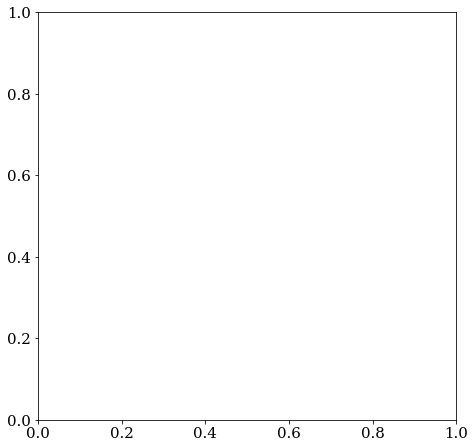

In [39]:
fig,ax = plt.subplots(figsize=(7.5,7.5))

ax.contour(x,y, toplot,COAR_p88[0],colors='k')
cont_levels = np.linspace(-8e4,8e4,25)
im = ax.contourf(x, y, toplot-toplot.mean(), cont_levels,
                 vmin = -8e4, vmax = 8e4, extend='both')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('(a) Time-mean MSE anomaly (day 85-100) in RCE')
cbar = plt.colorbar(im)